<a href="https://colab.research.google.com/github/Tarosh-Kuchroo/ECE562_Assignment1/blob/adithya_kumar/Q6_Pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'ece697ls/assignments/assignment3/'
FOLDERNAME = 'assignment1_colab/assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/assignment1_colab/assignment1'.format(FOLDERNAME))

%cd /content

Mounted at /content/drive
/content


# Pruning

After learning, neural networks have modified and learned a set of parameters to perform our classification task. However, such parameters are costly to maintain and do not hold the same importance.

Wouldn't it be great could optimize our resource usage by dropping less important values ? This is where pruning comes into play.

Pruning is a technique that cuts off parameters/structures from a model to increase sparcity and decrease overall model size, similar to cutting leafs or branches from bushes and trees. This process can lead to smaller memory consumption with minimal accuracy reduction. Moreover, pruning the network may also provide a speedup since there will be less operations being performed.

The pruning process can be performed during the end of an epoch of training or after training is complete. Experimenting to find out which way works the best is part of the fun !

In [ ]:
from ece662.pruning_helper import test_model, load_model
from ece662.data_utils import get_CINIC10_data
import os

Below we will load a pre-trained model for you to work on. If you prefer, you can save your own model from the previous Tensorflow/Pytorch task and load it here.

In [ ]:
#This code may take a while to execute as it is training a network form scratch

data = get_CINIC10_data()
mode = 'torch'#torch or tensorflow

test_data = [data['X_test'],data['y_test']]

path = os.path.join('/content/drive/My Drive/{}'.format(FOLDERNAME), f"ece662/models/{mode}.model")
if os.path.exists(path):
    print(f"Loading existing model from {path}")
    model = load_model(path, mode=mode)
else:
    print(f"Model not found at {path}")
    model = None # Explicitly set model to None if not loaded

# Check if the model was loaded before proceeding
if model is not None:
    test_model(model, test_data, mode=mode)
else:
    print("Model not loaded. Please ensure the model file exists at the specified path.")

Loading existing model from /content/drive/My Drive/assignment1_colab/assignment1/ece662/models/torch.model
Test Acc: 0.5038


## Unstructured Pruning

Unstructured Pruning is usually related to the pruning of weights in neural networks. The general idea is to select a set of weights according to a policy and setting them up to zero.

Common policies are random weight selection or selecting the smallers weights.
Unstructured Pruning can be performed in one or multiple layers within the same network.

Altough in theory Unstructured Pruning should decrease the number of operations performed during execution there should be explicit support within the framework or hardware to bypass such operations, otherwise it will just operated over zero.

### Perform Pruning

Using the model trained in the previous step using pytorch, perform unstructured pruning in the weights of the model by removing x% of the smallest weights.

*   Increment global pruning by 10% until reaching total of 80% pruned weights
*   Perform inference at the end of each pruning and observe the impact into the accuracy.


Note: The percentages are related to the entire model, not per layer.



Original Model (0% pruned)
Test Acc: 0.5076

Pruning 10% of weights
Test Acc: 0.5090
Calculated accuracy: 0.5117
Actual sparsity achieved: 10.00%

Pruning 20% of weights
Test Acc: 0.5066
Calculated accuracy: 0.5087
Actual sparsity achieved: 20.00%

Pruning 30% of weights
Test Acc: 0.4997
Calculated accuracy: 0.5063
Actual sparsity achieved: 30.00%

Pruning 40% of weights
Test Acc: 0.5031
Calculated accuracy: 0.4992
Actual sparsity achieved: 40.00%

Pruning 50% of weights
Test Acc: 0.4842
Calculated accuracy: 0.4836
Actual sparsity achieved: 50.00%

Pruning 60% of weights
Test Acc: 0.4909
Calculated accuracy: 0.4890
Actual sparsity achieved: 60.00%

Pruning 70% of weights
Test Acc: 0.4700
Calculated accuracy: 0.4756
Actual sparsity achieved: 70.00%

Pruning 80% of weights
Test Acc: 0.4125
Calculated accuracy: 0.4070
Actual sparsity achieved: 80.00%

PRUNING SUMMARY
Pruning %       Accuracy       
------------------------------
0               0.5090         
10              0.5117      

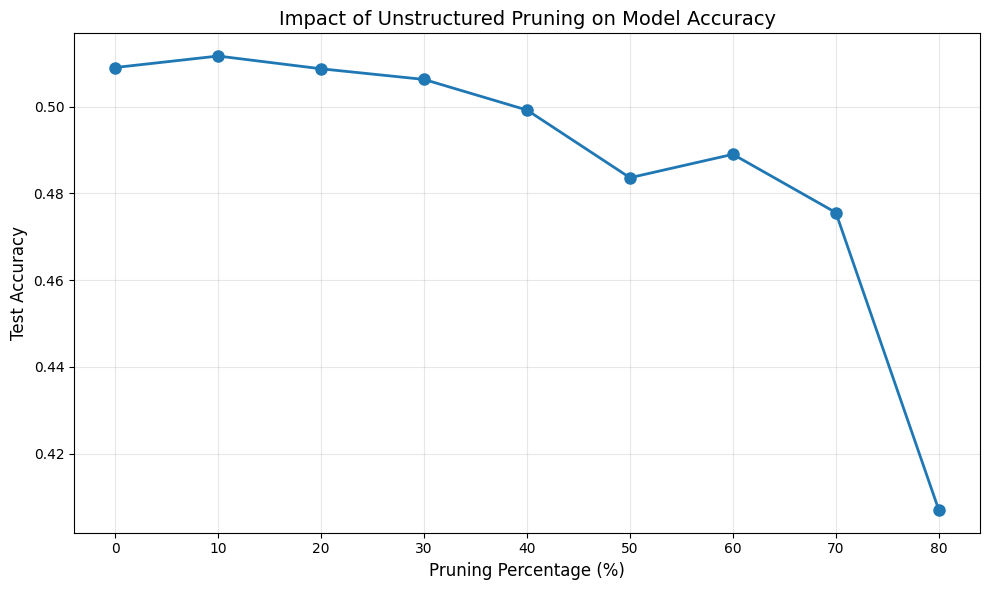

In [ ]:
################################################################################
# TODO: Perform unstructured Pruning over the trained model using 3 different
# prunning percentages.
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
import torch
import torch.nn.utils.prune as prune
import copy

# Store results
pruning_results = []

# Test original model first
print("="*50)
print("Original Model (0% pruned)")
print("="*50)
test_model(model, test_data, mode=mode)
# Get accuracy by manually computing it
with torch.no_grad():
    correct = 0
    total = 0
    X_test, y_test = test_data
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)

    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    total = y_test_tensor.size(0)
    correct = (predicted == y_test_tensor).sum().item()
    acc = correct / total

pruning_results.append((0, acc))

# Prune from 10% to 80% in increments of 10%
for pruning_percentage in range(10, 90, 10):
    print("\n" + "="*50)
    print(f"Pruning {pruning_percentage}% of weights")
    print("="*50)

    # Create a fresh copy of the original model for each pruning level
    # This ensures we always prune from the original, not from previously pruned model
    pruned_model = copy.deepcopy(model)

    # Get all parameters to prune (weights only, not biases)
    parameters_to_prune = []
    for name, module in pruned_model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))

    # Apply global unstructured pruning
    # This prunes the smallest weights globally across all specified parameters
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=pruning_percentage / 100.0,
    )

    # Make pruning permanent by removing the reparametrization
    for module, param_name in parameters_to_prune:
        prune.remove(module, param_name)

    # Test the pruned model
    test_model(pruned_model, test_data, mode=mode)

    # Calculate accuracy manually
    with torch.no_grad():
        correct = 0
        total = 0
        X_test, y_test = test_data
        X_test_tensor = torch.FloatTensor(X_test)
        y_test_tensor = torch.LongTensor(y_test)

        outputs = pruned_model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)
        total = y_test_tensor.size(0)
        correct = (predicted == y_test_tensor).sum().item()
        acc = correct / total
        print(f"Calculated accuracy: {acc:.4f}")

    pruning_results.append((pruning_percentage, acc))

    # Calculate sparsity (percentage of zeros)
    total_params = 0
    zero_params = 0
    for module, _ in parameters_to_prune:
        weight = module.weight
        total_params += weight.numel()
        zero_params += (weight == 0).sum().item()

    actual_sparsity = 100.0 * zero_params / total_params
    print(f"Actual sparsity achieved: {actual_sparsity:.2f}%")

# Print summary
print("\n" + "="*50)
print("PRUNING SUMMARY")
print("="*50)
print(f"{'Pruning %':<15} {'Accuracy':<15}")
print("-"*30)
for prune_pct, acc in pruning_results:
    if acc is not None:
        print(f"{prune_pct:<15} {acc:<15.4f}")
    else:
        print(f"{prune_pct:<15} {'N/A':<15}")

# Visualize results - filter out None values
import matplotlib.pyplot as plt

valid_results = [(pct, acc) for pct, acc in pruning_results if acc is not None]
pruning_percentages = [x[0] for x in valid_results]
accuracies = [x[1] for x in valid_results]

plt.figure(figsize=(10, 6))
plt.plot(pruning_percentages, accuracies, marker='o', linewidth=2, markersize=8)
plt.xlabel('Pruning Percentage (%)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Impact of Unstructured Pruning on Model Accuracy', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(pruning_percentages)
plt.tight_layout()
plt.show()
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

## Inline Question 1:

What happened with the accuracy as the % of pruning increased ?
Why was that the case?


## Answer:
The model’s accuracy remained fairly stable up to around 40% pruning, holding steady at about 50–51%. However, once pruning reached 50–60%, accuracy began to drop noticeably to around 48–49%. Beyond that point, performance declined sharply — at 70% pruning it fell to roughly 47%, and by 80% it dropped further to about 41%. In short, as the pruning level increased, the model’s accuracy steadily deteriorated.
This is why:
Deep neural networks often contain far more parameters than they actually need, with many weights being redundant—especially those with very small values that barely affect the model’s predictions. L1 unstructured pruning targets these less important weights first, which is why accuracy tends to stay almost unchanged at moderate pruning levels (around 10–40%). The remaining weights can easily make up for what’s been removed. But once pruning reaches 40–50%, the process starts cutting into weights that actually matter for the model’s decisions, leading to a gradual drop in performance. At extreme pruning levels (70–80%), so many parameters are removed that the network loses its ability to represent complex patterns in the data. As a result, accuracy falls sharply, since the model becomes too simplified to capture the detailed decision boundaries needed for accurate classification.


## Structured Pruning

Structured Pruning consists of removing a bigger chunk of the network parameters at the same time. Instead of removing only a few weights, it is commonplace to remove entire neurons.

For example, in Convolutional Layers, removing filters can be beneficial to improve performance as it greatly decreases the amount of computation performed. However, some of these changes may affect output dimensions which may be carried over to other parts of the network. Therefore, when performing structured pruning one must always be aware of which parameters are going to be affected.

Using the previously trained model in the CINIC-10, perform Structured Prunning only in the Convolution layers of the DNN.

Original Model (0% filters pruned)
Test Acc: 0.5115
Calculated accuracy: 0.5084
Total convolutional filters in model: 64


Pruning 10% of convolutional filters
Test Acc: 0.3853
Calculated accuracy: 0.3846
Actual filters pruned: 6/64 (9.38%)

Pruning 20% of convolutional filters
Test Acc: 0.2681
Calculated accuracy: 0.2705
Actual filters pruned: 12/64 (18.75%)

Pruning 30% of convolutional filters
Test Acc: 0.1779
Calculated accuracy: 0.1766
Actual filters pruned: 20/64 (31.25%)

Pruning 40% of convolutional filters
Test Acc: 0.1738
Calculated accuracy: 0.1756
Actual filters pruned: 26/64 (40.62%)

Pruning 50% of convolutional filters
Test Acc: 0.1866
Calculated accuracy: 0.1875
Actual filters pruned: 32/64 (50.00%)

Pruning 60% of convolutional filters
Test Acc: 0.2270
Calculated accuracy: 0.2277
Actual filters pruned: 38/64 (59.38%)

Pruning 70% of convolutional filters
Test Acc: 0.2095
Calculated accuracy: 0.2115
Actual filters pruned: 44/64 (68.75%)

Pruning 80% of convolutional fil

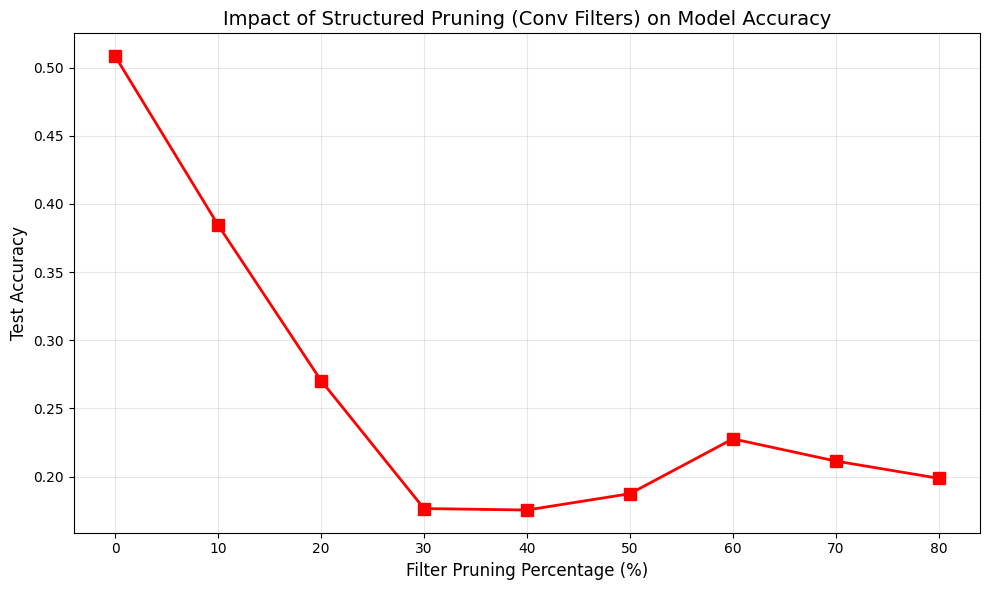

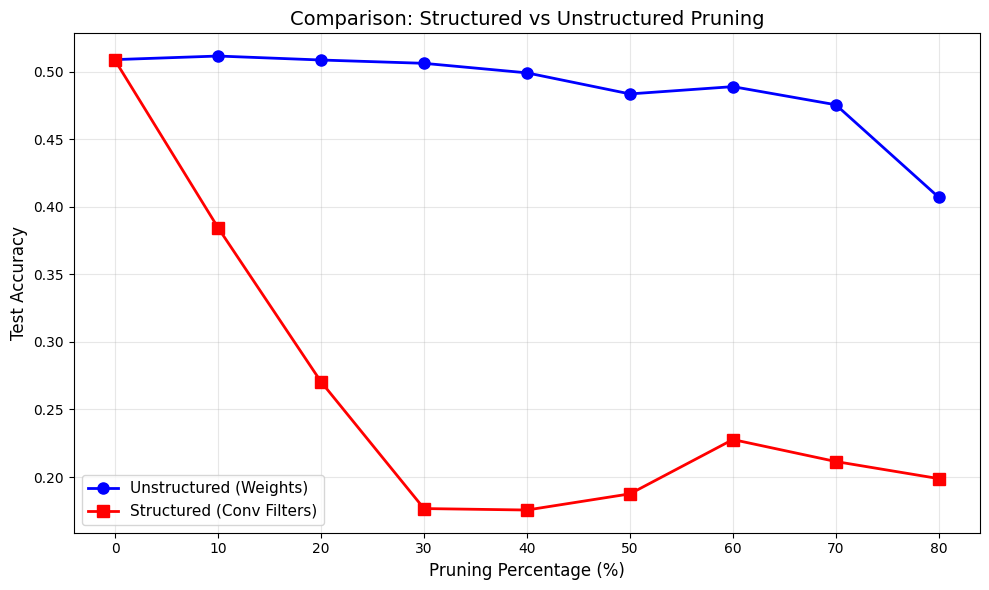

In [ ]:
################################################################################
# TODO: Perform unstrucuted Pruning over the trained model using 3 different
# prunning percentages.
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
import torch
import torch.nn.utils.prune as prune
import copy

# Store results for structured pruning
structured_results = []

# Test original model first
print("="*50)
print("Original Model (0% filters pruned)")
print("="*50)
test_model(model, test_data, mode=mode)

# Calculate original accuracy
with torch.no_grad():
    correct = 0
    total = 0
    X_test, y_test = test_data
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)

    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    total = y_test_tensor.size(0)
    correct = (predicted == y_test_tensor).sum().item()
    acc = correct / total
    print(f"Calculated accuracy: {acc:.4f}")

structured_results.append((0, acc))

# Count original filters
total_filters = 0
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        total_filters += module.out_channels
print(f"Total convolutional filters in model: {total_filters}\n")

# Prune filters from 10% to 80% in increments of 10%
for pruning_percentage in range(10, 90, 10):
    print("\n" + "="*50)
    print(f"Pruning {pruning_percentage}% of convolutional filters")
    print("="*50)

    # Create a fresh copy of the original model
    pruned_model = copy.deepcopy(model)

    # Identify all convolutional layers
    conv_layers = []
    for name, module in pruned_model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            conv_layers.append((name, module))

    # Apply structured pruning (remove entire filters) to conv layers
    for name, module in conv_layers:
        # Prune filters based on L1 norm (remove filters with smallest L1 norm)
        prune.ln_structured(
            module,
            name='weight',
            amount=pruning_percentage / 100.0,
            n=1,  # L1 norm
            dim=0  # Prune along output channel dimension (filters)
        )
        # Make pruning permanent
        prune.remove(module, 'weight')

    # Test the pruned model
    test_model(pruned_model, test_data, mode=mode)

    # Calculate accuracy manually
    with torch.no_grad():
        correct = 0
        total = 0
        X_test, y_test = test_data
        X_test_tensor = torch.FloatTensor(X_test)
        y_test_tensor = torch.LongTensor(y_test)

        outputs = pruned_model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)
        total = y_test_tensor.size(0)
        correct = (predicted == y_test_tensor).sum().item()
        acc = correct / total
        print(f"Calculated accuracy: {acc:.4f}")

    structured_results.append((pruning_percentage, acc))

    # Calculate actual number of pruned filters
    pruned_filters = 0
    remaining_filters = 0
    for name, module in pruned_model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            # Count filters where all weights are zero (pruned filters)
            filter_norms = torch.norm(module.weight.view(module.out_channels, -1), p=1, dim=1)
            pruned_filters += (filter_norms == 0).sum().item()
            remaining_filters += module.out_channels

    actual_filter_pruning = 100.0 * pruned_filters / total_filters
    print(f"Actual filters pruned: {pruned_filters}/{total_filters} ({actual_filter_pruning:.2f}%)")

# Print summary
print("\n" + "="*50)
print("STRUCTURED PRUNING SUMMARY")
print("="*50)
print(f"{'Pruning %':<15} {'Accuracy':<15}")
print("-"*30)
for prune_pct, acc in structured_results:
    if acc is not None:
        print(f"{prune_pct:<15} {acc:<15.4f}")
    else:
        print(f"{prune_pct:<15} {'N/A':<15}")

# Visualize results
import matplotlib.pyplot as plt

valid_results = [(pct, acc) for pct, acc in structured_results if acc is not None]
pruning_percentages = [x[0] for x in valid_results]
accuracies = [x[1] for x in valid_results]

plt.figure(figsize=(10, 6))
plt.plot(pruning_percentages, accuracies, marker='s', linewidth=2, markersize=8, color='red')
plt.xlabel('Filter Pruning Percentage (%)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Impact of Structured Pruning (Conv Filters) on Model Accuracy', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(pruning_percentages)
plt.tight_layout()
plt.show()

# Compare structured vs unstructured pruning
if len(pruning_results) > 0 and len(structured_results) > 0:
    plt.figure(figsize=(10, 6))

    # Unstructured pruning
    valid_unstructured = [(pct, acc) for pct, acc in pruning_results if acc is not None]
    unstructured_pcts = [x[0] for x in valid_unstructured]
    unstructured_accs = [x[1] for x in valid_unstructured]

    # Structured pruning
    valid_structured = [(pct, acc) for pct, acc in structured_results if acc is not None]
    structured_pcts = [x[0] for x in valid_structured]
    structured_accs = [x[1] for x in valid_structured]

    plt.plot(unstructured_pcts, unstructured_accs, marker='o', linewidth=2,
             markersize=8, label='Unstructured (Weights)', color='blue')
    plt.plot(structured_pcts, structured_accs, marker='s', linewidth=2,
             markersize=8, label='Structured (Conv Filters)', color='red')

    plt.xlabel('Pruning Percentage (%)', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.title('Comparison: Structured vs Unstructured Pruning', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

## Inline Question 2:

What is the difference between performing Structured Pruning vs Dropout ?
Why would it be beneficial to perform both techniques when developing a Neural Network?


## Answer:
Dropout works by temporarily and randomly turning off certain neurons during training, which helps prevent overfitting and improves the model’s ability to generalize. In contrast, structured pruning permanently removes entire components of the network—such as filters or neurons—after training, with the goal of making the model smaller and faster during inference.
Dropout helps a network learn redundant and robust representations by preventing neurons from co-adapting, allowing multiple pathways to solve the same task. This makes the model more resilient to structured pruning, since removing entire filters or neurons is less likely to harm performance when the remaining ones can compensate. While dropout reduces overfitting during training, pruning improves efficiency and compression after training. Together, they yield a model that stays accurate and robust while being lighter and faster for deployment.
